# Project: Identify Customer Segments

In this project, unsupervised learning methods are employed to identify population segments that are most representative of the core customer base of a mail-order sales company operating in Germany. The resulting segments can subsequently be leveraged to guide marketing efforts toward groups that are expected to yield higher response and return rates. The dataset used in this study is provided by Bertelsmann Arvato Analytics and reflects a real-world data science application.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import gc
import sklearn
import time
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

This project uses two demographic datasets (`AZDIAS` for the general population and `CUSTOMERS` for mail-order customers), along with supporting metadata files (`Data_Dictionary` and `Feature_Summary`). Each row represents an individual, with additional household and neighborhood-level attributes.

In this step, the `AZDIAS` dataset and the feature summary are loaded into pandas. All CSV files are semicolon (;) delimited, so the appropriate separator is required in `read_csv()`. A brief inspection of dataset shape and feature information is performed to establish initial familiarity before preprocessing and clustering.

Note: The raw data is not included in this repository due to licensing/privacy restrictions; only the code and methodology are provided.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("General demographics data(AZDİAS) shape:", azdias.shape)
print("Feature summary file shape:", feat_info.shape)

General demographics data(AZDİAS) shape: (891221, 85)
Feature summary file shape: (85, 4)


In [4]:
# print first few rows in AZDİAS dataset
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
# print first few rows in feature summary
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary (`feat_info`) is used to guide preprocessing decisions, particularly for handling missing or unknown values. In this step, missingness patterns in the demographics data are examined and the key observations are documented in the Discussion section.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The missing/unknown value indicators are provided in the fourth column of `feat_info`. Since these codes are read as strings (e.g., `[-1,0]`), they are parsed into Python lists and then used to replace corresponding entries in the dataset with `np.nan`. This conversion enables consistent missing-value handling in subsequent cleaning steps. Optionally, the proportion of values represented by these codes versus naturally occurring `NaNs` is computed for comparison.

In [6]:
azdias_na = azdias.copy()

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

missing_map = {}
for _ , row in feat_info.iterrows():
    col = row['attribute']
    raw = row['missing_or_unknown']
    if isinstance(raw, str):
        try:
            codes = ast.literal_eval(raw)
            if not isinstance(codes, list):
                codes = [codes]
        except(ValueError, SyntaxError):
            raw = raw.strip("[]")
            codes = [r.strip() for r in raw.split(",") if r.strip()]
    else: 
        codes = []
    missing_map[col] = codes
    
for col, codes in missing_map.items():
    if col in azdias_na.columns and codes:
        azdias_na[col] = azdias_na[col].replace(codes, np.nan)

In [8]:
print("AZDIAS NaNs before/after:",
      azdias.isna().sum().sum(), "→", azdias_na.isna().sum().sum())

AZDIAS NaNs before/after: 4896838 → 8373929


In [9]:
for c in ["CAMEO_DEU_2015", "CAMEO_DEUG_2015", "CAMEO_INTL_2015"]:
    if c in azdias.columns:
        print(f"\n[{c}] BEFORE top:")
        print(azdias[c].value_counts(dropna=False).head(5))
        print(f"[{c}] AFTER top:")
        print(azdias_na[c].value_counts(dropna=False).head(5))



[CAMEO_DEU_2015] BEFORE top:
CAMEO_DEU_2015
NaN    98979
6B     56672
8A     52438
4C     47819
2D     35074
Name: count, dtype: int64
[CAMEO_DEU_2015] AFTER top:
CAMEO_DEU_2015
NaN    99352
6B     56672
8A     52438
4C     47819
2D     35074
Name: count, dtype: int64

[CAMEO_DEUG_2015] BEFORE top:
CAMEO_DEUG_2015
8      134441
9      108177
6      105874
4      103912
NaN     98979
Name: count, dtype: int64
[CAMEO_DEUG_2015] AFTER top:
CAMEO_DEUG_2015
8      134441
9      108177
6      105874
4      103912
NaN     99352
Name: count, dtype: int64

[CAMEO_INTL_2015] BEFORE top:
CAMEO_INTL_2015
51     133694
NaN     98979
41      92336
24      91158
14      62884
Name: count, dtype: int64
[CAMEO_INTL_2015] AFTER top:
CAMEO_INTL_2015
51     133694
NaN     99352
41      92336
24      91158
14      62884
Name: count, dtype: int64


In [10]:
check_cols = ["CJT_GESAMTTYP", "ANREDE_KZ", "ALTERSKATEGORIE_GROB"]
for c in check_cols:
    if c in azdias.columns:
        print(f"\n[{c}] BEFORE")
        print(azdias[c].value_counts(dropna=False).head(10))
        print(f"\n[{c}] AFTER")
        print(azdias_na[c].value_counts(dropna=False).head(10))


[CJT_GESAMTTYP] BEFORE
CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
NaN      4854
Name: count, dtype: int64

[CJT_GESAMTTYP] AFTER
CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
NaN      4854
Name: count, dtype: int64

[ANREDE_KZ] BEFORE
ANREDE_KZ
2    465305
1    425916
Name: count, dtype: int64

[ANREDE_KZ] AFTER
ANREDE_KZ
2    465305
1    425916
Name: count, dtype: int64

[ALTERSKATEGORIE_GROB] BEFORE
ALTERSKATEGORIE_GROB
3    358533
4    228510
2    158410
1    142887
9      2881
Name: count, dtype: int64

[ALTERSKATEGORIE_GROB] AFTER
ALTERSKATEGORIE_GROB
3.0    358533
4.0    228510
2.0    158410
1.0    142887
NaN      2881
Name: count, dtype: int64


#### Step 1.1.2: Assess Missing Data in Each Column

In this step, the amount of missing data is quantified for each feature. The distribution of missing-value counts (or proportions) across columns is visualized using `matplotlib.pyplot.hist()` to highlight features with unusually high missingness. Columns identified as clear outliers are documented and removed from the DataFrame for the purposes of this project.

For the remaining features, missingness patterns are briefly examined to determine whether specific groups of columns tend to be missing together (e.g., shared domain/feature type), and the observations are summarized in the Discussion section.

Top 40 columns by % missing:


,missing_count,missing_percent
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG1,133324,14.96


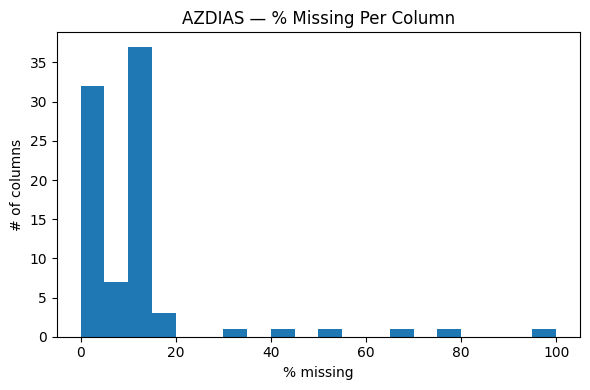

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

df = azdias_na

miss_count = df.isna().sum().sort_values(ascending = False)
miss_pct = ((miss_count / len(df)) * 100).round(2)

miss_summary = pd.DataFrame({'missing_count': miss_count, 'missing_percent': miss_pct})
print("Top 40 columns by % missing:")
display(miss_summary.head(40))

plt.figure(figsize=(6,4))
plt.hist(miss_summary['missing_percent'], bins=range(0, 101, 5))
plt.title("AZDIAS — % Missing Per Column")
plt.xlabel("% missing")
plt.ylabel("# of columns")
plt.tight_layout()
plt.show()


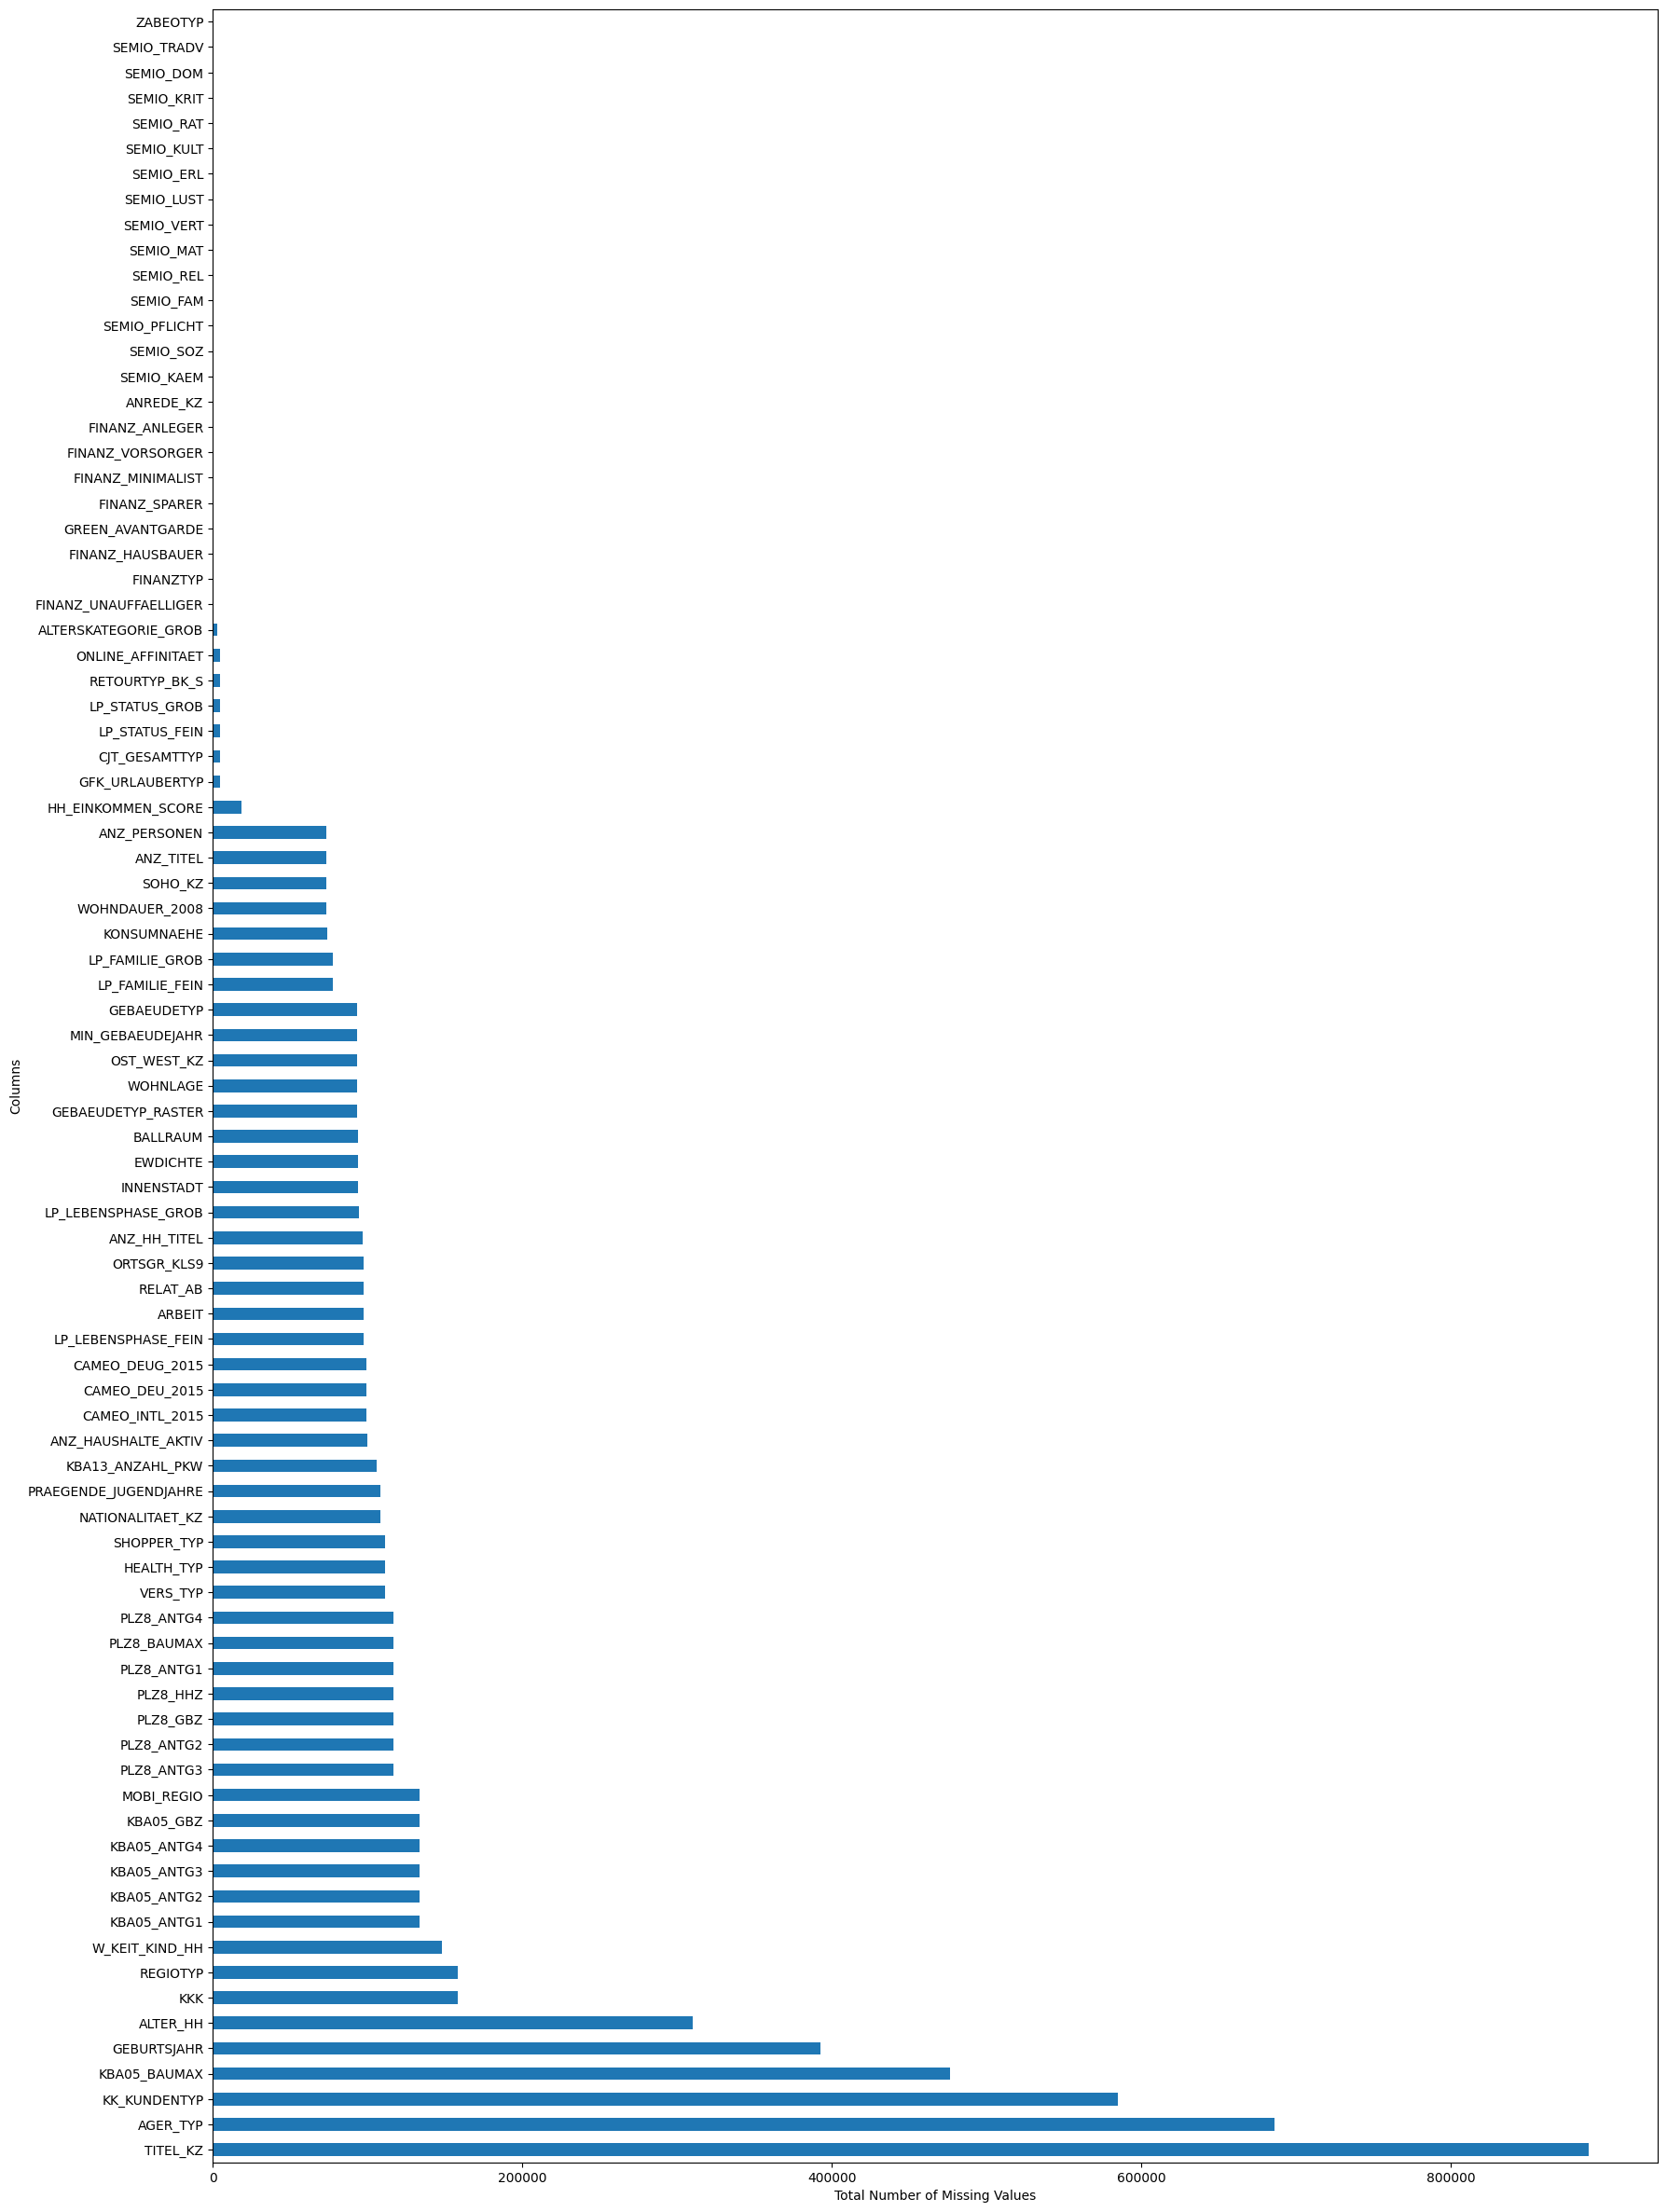

In [12]:
# Investigate patterns in the amount of missing data in each column.

miss_count.plot.barh(figsize=(20,30))
plt.xlabel('Total Number of Missing Values')
plt.ylabel('Columns')
plt.show()

In [13]:
df = azdias_na
missing_mask = df.isna().astype("uint8")
miss_corr = missing_mask.corr(method = "pearson")
upper = miss_corr.where(np.triu(np.ones_like(miss_corr, dtype = bool), k = 1))
pairs = upper.stack().sort_values(ascending = False)
strong_pairs = pairs[pairs >= 0.50].head(30)

print("\nStrong co-missing pairs (corr ≥ 0.50):")
display(strong_pairs)


Strong co-missing pairs (corr ≥ 0.50):


KBA05_ANTG2      KBA05_GBZ            1.0
PLZ8_ANTG1       PLZ8_GBZ             1.0
PLZ8_BAUMAX      PLZ8_HHZ             1.0
                 PLZ8_GBZ             1.0
GFK_URLAUBERTYP  RETOURTYP_BK_S       1.0
EWDICHTE         INNENSTADT           1.0
BALLRAUM         INNENSTADT           1.0
GFK_URLAUBERTYP  ONLINE_AFFINITAET    1.0
BALLRAUM         EWDICHTE             1.0
KBA05_GBZ        MOBI_REGIO           1.0
PLZ8_HHZ         PLZ8_GBZ             1.0
HEALTH_TYP       SHOPPER_TYP          1.0
                 VERS_TYP             1.0
LP_FAMILIE_FEIN  LP_FAMILIE_GROB      1.0
LP_STATUS_FEIN   LP_STATUS_GROB       1.0
                 RETOURTYP_BK_S       1.0
KBA05_ANTG4      MOBI_REGIO           1.0
                 KBA05_GBZ            1.0
LP_STATUS_FEIN   ONLINE_AFFINITAET    1.0
KBA05_ANTG3      MOBI_REGIO           1.0
LP_STATUS_GROB   RETOURTYP_BK_S       1.0
KBA05_ANTG3      KBA05_GBZ            1.0
                 KBA05_ANTG4          1.0
GFK_URLAUBERTYP  LP_STATUS_GROB   

In [14]:
# Remove the outlier columns from the dataset. 

THRESH = 30.0 

# List Outliers
outlier_cols = miss_summary.index[miss_summary['missing_percent'] > THRESH].tolist()

print(f"Outlier columns flagged (> {THRESH}% missing): {len(outlier_cols)}")
display(miss_summary.loc[outlier_cols].sort_values('missing_percent', ascending=False))

# Drop 
azdias_drop = df.drop(columns=outlier_cols)
print("Shape before:", df.shape, " | after drop:", azdias_drop.shape)


Outlier columns flagged (> 30.0% missing): 6


,missing_count,missing_percent
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81


Shape before: (891221, 85)  | after drop: (891221, 79)


In [15]:
azdias_na.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [16]:
azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

First, I checked the correlations of missing values, I found some columns that always go missing together (corr = 1.0). For example, many postcode-based features (PLZ8_*), car-related features (KBA05_*), and family/status variables (LP_FAMILIE, LP_STATUS) share the same missingness. For the project, I realized that these columns don’t bring independent information. If needed, I can drop one of the duplicates or treat them as a block during imputation.

I checked the percentage of missing values in each column and decided to drop features with more than 30% missing data. In total, 6 columns were removed: TITEL_KZ (99.8%), AGER_TYP (77.0%), KK_KUNDENTYP (65.6%), KBA05_BAUMAX (53.5%), GEBURTSJAHR (44.0%), and ALTER_HH (34.8%).

Since these features had a very high proportion of missing values, it didn’t make much sense to keep them or try to impute them. After removing them, the dataset shape changed from (891,221 × 85) to (891,221 × 79). This should make the next steps easier and more reliable.

#### Step 1.1.3: Assess Missing Data in Each Row

In this step, missingness is evaluated at the row level by counting the number (or proportion) of missing values per observation. Based on the observed distribution, the dataset is split into two subsets using a chosen threshold:

1. rows with missingness above the threshold, and

2. rows with missingness below the threshold.

To decide how to treat the high-missingness subset, distributions of several low-missingness (or nearly complete) features are compared between the two groups. At least five representative columns are selected, and frequency plots (e.g., countplot) are used to visualize whether the groups exhibit similar or systematically different patterns. To avoid repetition, a small helper function may be defined to generate these side-by-side comparisons.

Regardless of the outcome, the subsequent analysis is continued using only the subset with relatively few missing values, while any notable differences observed in the high-missingness group are recorded for interpretation in later stages.

    missing_count  missing_pct
0              49        57.65
1               4         4.71
2               4         4.71
3               9        10.59
4               3         3.53
5               2         2.35
6               5         5.88
7               4         4.71
8               4         4.71
9               3         3.53
10              3         3.53
11             53        62.35
12             10        11.76
13             11        12.94
14             53        62.35
15             11        12.94
16              9        10.59
17             53        62.35
18              9        10.59
19              5         5.88
20             16        18.82
21              6         7.06
22              6         7.06
23             11        12.94
24             53        62.35
25              9        10.59
26             24        28.24
27              5         5.88
28              4         4.71
29              4         4.71
30             40        47.06
31      

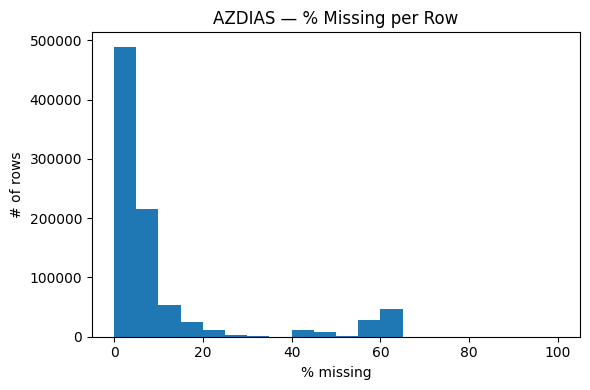

In [17]:
# How much data is missing in each row of the dataset?

row_miss_cnt = df.isna().sum(axis=1)

row_miss_pct = (row_miss_cnt / df.shape[1] * 100).round(2)

row_miss_summary = pd.DataFrame({
    "missing_count": row_miss_cnt,
    "missing_pct": row_miss_pct
})

print(row_miss_summary.head(40))

plt.figure(figsize=(6,4))
plt.hist(row_miss_summary["missing_pct"], bins=range(0, 101, 5))
plt.title("AZDIAS — % Missing per Row")
plt.xlabel("% missing")
plt.ylabel("# of rows")
plt.tight_layout()
plt.show()

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

df = azdias_drop
num_null_rows = df.isna().sum(axis=1)
ROW_THRESH = 30.0 

rows_high_missing = df[row_miss_summary["missing_pct"] > ROW_THRESH]
rows_low_missing  = df[row_miss_summary["missing_pct"] <= ROW_THRESH]

print("Rows with high missing:", rows_high_missing.shape)
print("Rows with low  missing:", rows_low_missing.shape)


col_miss_cnt = df.isna().sum()
col_miss_pct = (col_miss_cnt / len(df) * 100)
few_missing_cols = col_miss_pct[col_miss_pct < 5].sort_values().index
cols_to_check = list(few_missing_cols[:5])
print("Columns compared:", cols_to_check)

Rows with high missing: (93837, 79)
Rows with low  missing: (797384, 79)
Columns compared: ['SEMIO_SOZ', 'SEMIO_ERL', 'SEMIO_LUST', 'SEMIO_VERT', 'SEMIO_MAT']


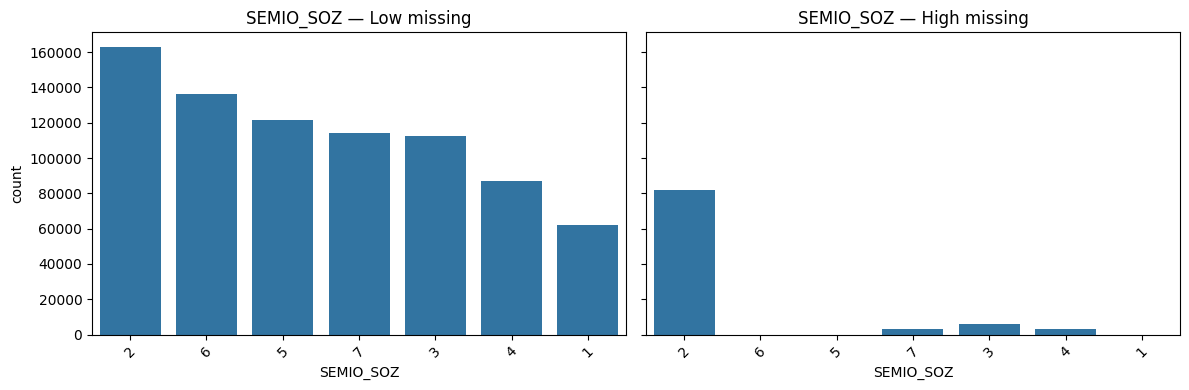

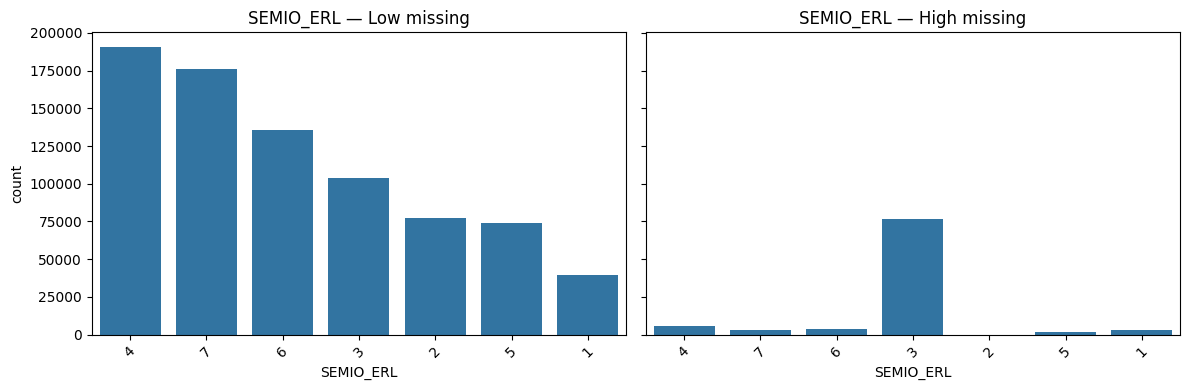

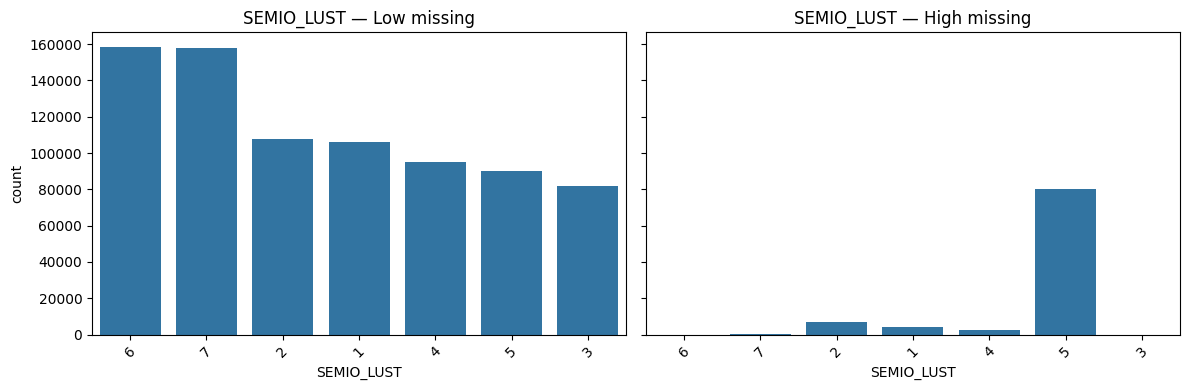

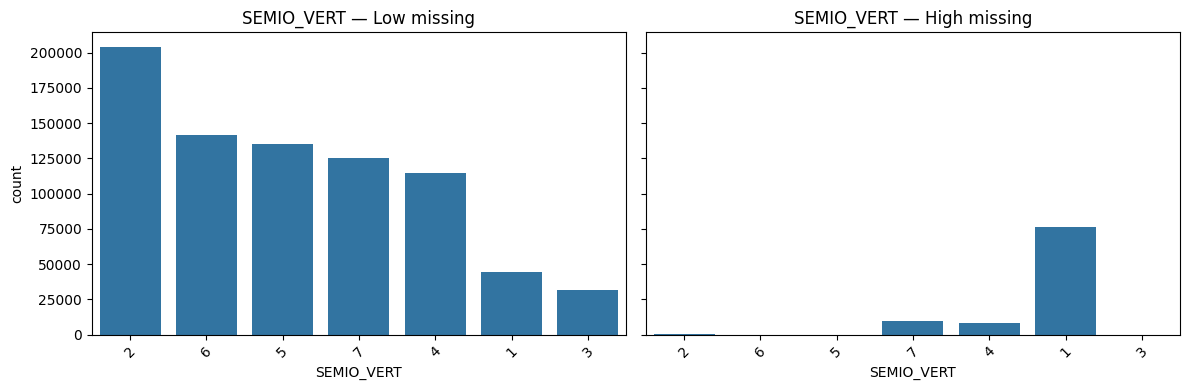

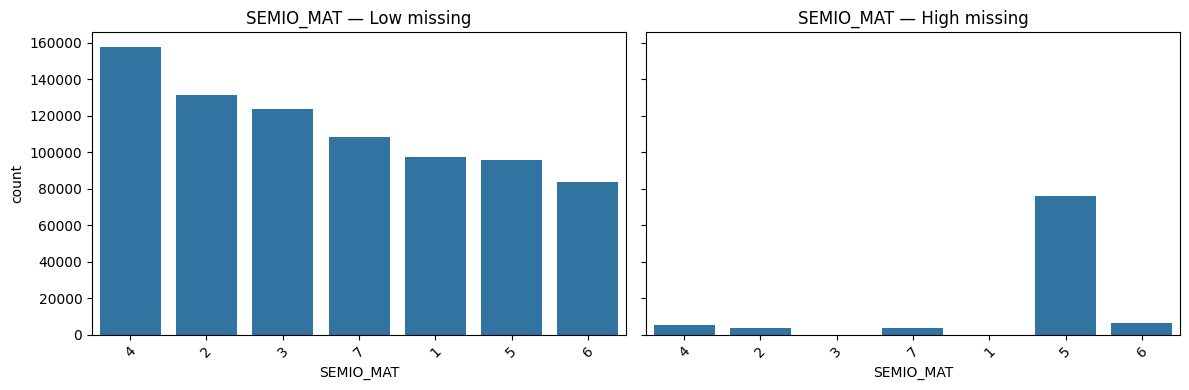

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distribution(col, low_df, high_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    sns.countplot(data=low_df,  x=col, ax=axes[0],
                  order=low_df[col].value_counts(dropna=True).index)
    axes[0].set_title(f"{col} — Low missing")
    axes[0].set_xlabel(col); axes[0].set_ylabel("count")

    sns.countplot(data=high_df, x=col, ax=axes[1],
                  order=low_df[col].value_counts(dropna=True).index)  # same order for fair view
    axes[1].set_title(f"{col} — High missing")
    axes[1].set_xlabel(col); axes[1].set_ylabel("")

    for ax in axes: ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

for col in cols_to_check:
    if col in rows_low_missing.columns:
        compare_distribution(col, rows_low_missing, rows_high_missing)

In [20]:
print("Low-missing value counts:")
print(rows_low_missing['SEMIO_SOZ'].value_counts(dropna=True).head(10))

print("\nHigh-missing value counts:")
print(rows_high_missing['SEMIO_SOZ'].value_counts(dropna=True).head(10))

Low-missing value counts:
SEMIO_SOZ
2    163068
6    136202
5    121778
7    114399
3    112727
4     87122
1     62088
Name: count, dtype: int64

High-missing value counts:
SEMIO_SOZ
2    81646
3     6162
4     3039
7     2979
5        8
6        3
Name: count, dtype: int64


#### Discussion 1.1.3: Assess Missing Data in Each Row

I split rows by a 30% row-missing threshold. Comparing five low-missing features (SEMIO_SOZ, SEMIO_ERL, SEMIO_LUST, SEMIO_VERT, SEMIO_MAT), the high-missing subset collapses into one/few categories, while the low-missing subset shows broad distributions. This aligns with earlier block-missing patterns, suggesting the high-missing rows form a special subpopulation and would yield unreliable imputations. I proceed with the low-missing subset for imputation, scaling, PCA, and clustering; I keep the high-missing rows aside for reference.

### Step 1.2: Select and Re-Encode Features

Since unsupervised learning algorithms require numerical inputs, additional preprocessing is needed beyond handling missing values. Although most features are stored as numbers, not all represent true numeric measurements. Feature types are reviewed using the third column of the feature summary (`feat_info`).

* Numeric and interval features are retained as-is.

* Ordinal features are also kept, under the simplifying assumption that they can be treated as interval-scaled.

* Categorical and mixed-type features may require special handling.

Accordingly, categorical and mixed features are examined and, for each, a decision is made to keep, drop, or re-encode. Finally, a cleaned and engineered dataset is constructed using only the selected features.

This wrangling stage is the most time-intensive part of the workflow, but completing it prepares the data for clustering and dimensionality reduction in the subsequent steps.

In [21]:
# How many features are there of each data type?

feat_type_counts = feat_info.iloc[:, 2].value_counts()
print("Number of features by type:")
for t, c in feat_type_counts.items():
    print(f"{t}: {c}")

Number of features by type:
ordinal: 49
categorical: 21
numeric: 7
mixed: 7
interval: 1


#### Step 1.2.1: Re-Encode Categorical Features

Categorical features are reviewed to ensure compatibility with the unsupervised learning pipeline.

* Binary categorical variables that are already numerically encoded are retained without modification.

* The single binary feature containing non-numeric labels is converted into a numeric representation (or equivalently transformed into a dummy variable).

* For categorical variables with three or more levels, either one-hot encoding is applied (e.g., via OneHotEncoder) or the feature is removed to keep the feature space manageable.

In [22]:
azdias_drop = azdias_drop.loc[rows_low_missing.index]
df = azdias_drop.copy()

In [23]:
print("azdias_drop shape:", azdias_drop.shape)
print("df shape:", df.shape)

print("\nRow count before filtering:", len(row_miss_summary))
print("Row count after filtering :", len(df))

azdias_drop shape: (797384, 79)
df shape: (797384, 79)

Row count before filtering: 891221
Row count after filtering : 797384


In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_cols = feat_info.loc[feat_info['type'] == 'categorical', 'attribute']
cat_cols = [c for c in cat_cols if c in df.columns]

cat_levels = df[cat_cols].nunique(dropna=True).sort_values(ascending=False)

binary_cols = cat_levels[cat_levels == 2].index.tolist()
multi_cols  = cat_levels[cat_levels >= 3].index.tolist()
 
binary_non_numeric = [c for c in binary_cols if not is_numeric_dtype(df[c])]
binary_numeric     = [c for c in binary_cols if c not in binary_non_numeric]

print("Categorical features:", len(cat_cols))
print("  Binary (numeric):   ", binary_numeric)
print("  Binary (non-numeric):", binary_non_numeric)
print("  Multi-level (>=3):   ", len(multi_cols), "columns")

Categorical features: 18
  Binary (numeric):    ['VERS_TYP', 'SOHO_KZ', 'GREEN_AVANTGARDE', 'ANREDE_KZ']
  Binary (non-numeric): ['OST_WEST_KZ']
  Multi-level (>=3):    13 columns


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.

if 'OST_WEST_KZ' in df.columns:
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})

df = df.drop(columns=[c for c in multi_cols if c in df.columns], errors='ignore')

print("After dropping 13 multi-level categoricals:", df.shape)


After dropping 13 multi-level categoricals: (797384, 66)


#### Discussion 1.2.1: Re-Encode Categorical Features

I identified 18 categorical features in total. Four of them were already numeric and binary (VERS_TYP, SOHO_KZ, GREEN_AVANTGARDE, ANREDE_KZ), so I kept them unchanged. The one binary non-numeric variable, OST_WEST_KZ, was re-encoded so that ‘W’ → 1 and ‘O’ → 0, with missing values preserved as NaN.

For the 13 multi-level categorical variables, I decided to drop them entirely. This choice was made to avoid the curse of dimensionality and prevent diluting the variability captured by PCA, since one-hot encoding would have expanded the feature space significantly.

After Step 1.1.2 (dropping high-missing columns), the dataset had 79 features. Following categorical handling, the dataset now contains 66 fully numeric features, ready for mixed-type processing, imputation, scaling, and clustering.

#### Step 1.2.2: Engineer Mixed-Type Features

Mixed-type features require additional preprocessing before they can be used in the analysis. Two key variables are explicitly engineered:

- `PRAEGENDE_JUGENDJAHRE` is decomposed to represent (1) an interval-like decade variable and (2) a binary movement indicator (mainstream vs. avantgarde).

- `CAMEO_INTL_2015` is split into two ordinal variables by separating the two-digit code into its tens and ones digits, capturing wealth and life stage, respectively.

Any additional mixed-type features are either engineered further or excluded, depending on their interpretability and usefulness. All feature-engineering decisions and transformations are documented in the Discussion section, with reference to `Data_Dictionary.md` where needed.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

col = "PRAEGENDE_JUGENDJAHRE"
if col in df.columns:
    decade_map = {
        1: 1940, 2: 1940,
        3: 1950, 4: 1950,
        5: 1960, 6: 1960, 7: 1960,
        8: 1970, 9: 1970,
        10: 1980, 11: 1980, 12: 1980, 13: 1980,
        14: 1990, 15: 1990
    }

    avant_codes = {2, 4, 6, 7, 9, 11, 13, 15}
    main_codes  = {1, 3, 5, 8, 10, 12, 14}

    s = df[col]

    df["PJ_DECADE"] = s.map(decade_map).astype("float")

    df["PJ_AVANTGARDE"] = np.where(s.isin(avant_codes), 1.0,
                               np.where(s.isin(main_codes), 0.0, np.nan))

    print(df[["PRAEGENDE_JUGENDJAHRE","PJ_DECADE","PJ_AVANTGARDE"]].head())
else:
    print(f"Column '{col}' not found in dataframe.")

   PRAEGENDE_JUGENDJAHRE  PJ_DECADE  PJ_AVANTGARDE
1                   14.0     1990.0            0.0
2                   15.0     1990.0            1.0
3                    8.0     1970.0            0.0
4                    8.0     1970.0            0.0
5                    3.0     1950.0            0.0


In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

col = "CAMEO_INTL_2015"
if col in df.columns:
    s = df[col]

    s_num = pd.to_numeric(s, errors='coerce')

    valid = s_num.between(11, 55)

    wealth = pd.Series(np.nan, index=df.index, dtype="float")
    life   = pd.Series(np.nan, index=df.index, dtype="float")

    wealth.loc[valid] = (s_num.loc[valid] // 10).astype(float)
    life.loc[valid]   = (s_num.loc[valid] % 10).astype(float)

    df["WEALTH"] = wealth
    df["LIFE_STAGE"] = life

    print(df[[col, "WEALTH", "LIFE_STAGE"]].head())
    print("\nWEALTH unique (non-null):", sorted(df["WEALTH"].dropna().unique().tolist())[:10], "…")
    print("LIFE_STAGE unique (non-null):", sorted(df["LIFE_STAGE"].dropna().unique().tolist())[:10], "…")
else:
    print(f"Column '{col}' not found in dataframe.")

  CAMEO_INTL_2015  WEALTH  LIFE_STAGE
1              51     5.0         1.0
2              24     2.0         4.0
3              12     1.0         2.0
4              43     4.0         3.0
5              54     5.0         4.0

WEALTH unique (non-null): [1.0, 2.0, 3.0, 4.0, 5.0] …
LIFE_STAGE unique (non-null): [1.0, 2.0, 3.0, 4.0, 5.0] …


PJ_DECADE distribution:
 PJ_DECADE
1940.0     28150
1950.0     74283
1960.0    114328
1970.0    175098
1980.0    151705
1990.0    225439
NaN        28381
Name: count, dtype: int64 

PJ_AVANTGARDE distribution:
 PJ_AVANTGARDE
0.0    593831
1.0    175172
NaN     28381
Name: count, dtype: int64 

WEALTH distribution:
 WEALTH
1.0    119367
2.0    190511
3.0     68128
4.0    189905
5.0    223522
NaN      5951
Name: count, dtype: int64 

LIFE_STAGE distribution:
 LIFE_STAGE
1.0    244964
2.0     77254
3.0    119571
4.0    232658
5.0    116986
NaN      5951
Name: count, dtype: int64 



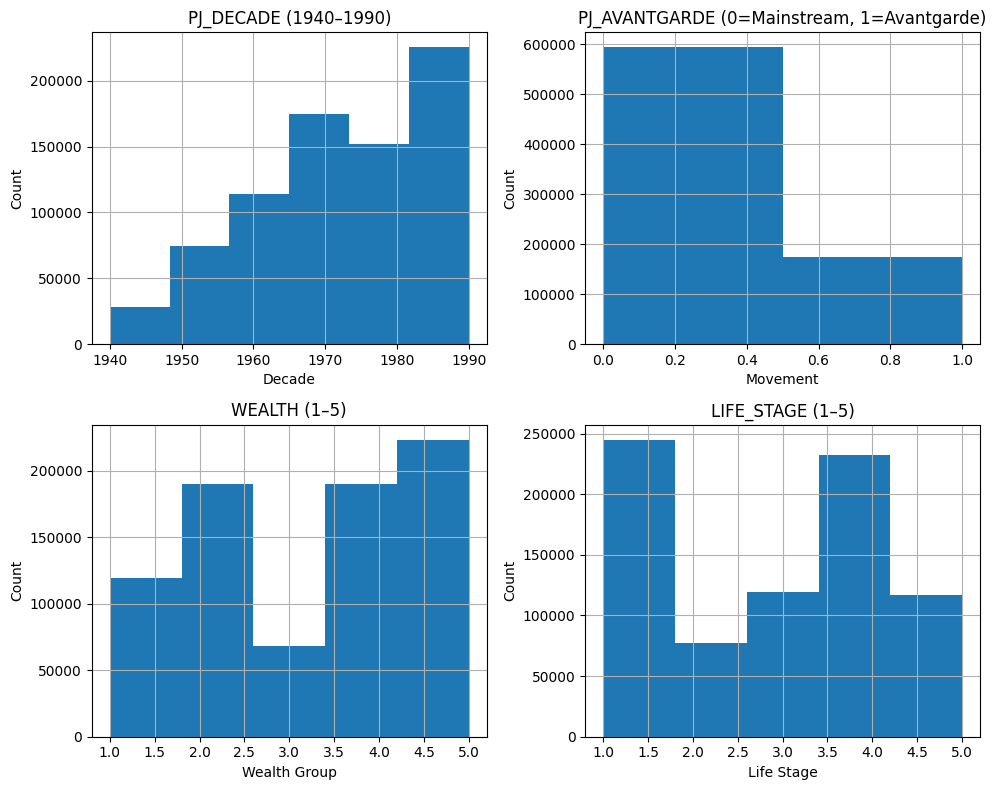

In [28]:
# Value counts 
print("PJ_DECADE distribution:\n", df["PJ_DECADE"].value_counts(dropna=False).sort_index(), "\n")
print("PJ_AVANTGARDE distribution:\n", df["PJ_AVANTGARDE"].value_counts(dropna=False).sort_index(), "\n")
print("WEALTH distribution:\n", df["WEALTH"].value_counts(dropna=False).sort_index(), "\n")
print("LIFE_STAGE distribution:\n", df["LIFE_STAGE"].value_counts(dropna=False).sort_index(), "\n")

# Histograms
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

df["PJ_DECADE"].dropna().astype(int).hist(bins=6, ax=axs[0,0])
axs[0,0].set_title("PJ_DECADE (1940–1990)")
axs[0,0].set_xlabel("Decade")
axs[0,0].set_ylabel("Count")

df["PJ_AVANTGARDE"].dropna().astype(int).hist(bins=2, ax=axs[0,1])
axs[0,1].set_title("PJ_AVANTGARDE (0=Mainstream, 1=Avantgarde)")
axs[0,1].set_xlabel("Movement")
axs[0,1].set_ylabel("Count")

df["WEALTH"].dropna().astype(int).hist(bins=5, ax=axs[1,0])
axs[1,0].set_title("WEALTH (1–5)")
axs[1,0].set_xlabel("Wealth Group")
axs[1,0].set_ylabel("Count")

df["LIFE_STAGE"].dropna().astype(int).hist(bins=5, ax=axs[1,1])
axs[1,1].set_title("LIFE_STAGE (1–5)")
axs[1,1].set_xlabel("Life Stage")
axs[1,1].set_ylabel("Count")

plt.tight_layout()
plt.show()

#### Discussion 1.2.2: Engineer Mixed-Type Features
In this step I worked on the mixed-type features to make them usable in the analysis.

For PRAEGENDE_JUGENDJAHRE, I left out the east/west part since it couldn’t really be separated, and instead created two new variables: PJ_DECADE (showing the birth decade from the 1940s up to the 1990s) and PJ_AVANTGARDE (0 for mainstream, 1 for avantgarde). Most people turned out to be in the mainstream group, and the younger decades were especially common.

For CAMEO_INTL_2015, I split the two-digit code into two pieces: WEALTH (the tens digit, 1–5) and LIFE_STAGE (the ones digit, 1–5). This gave a nice spread across the categories, with only a small amount of missing data.

#### Step 1.2.3: Complete Feature Selection

To finalize preprocessing, the dataset is restricted to the set of features selected for modeling:

* all numeric, interval, and ordinal columns from the original data,

* binary categorical features that are already numerically encoded,

* and any engineered variables derived from multi-level categorical and mixed-type features.

For engineered features, the original source columns are removed to avoid redundancy and unintended influence during later analysis (e.g., PRAEGENDE_JUGENDJAHRE is excluded after its components are extracted). In addition, all subsequent steps are performed using only the subset of rows with relatively few missing values.

In [29]:
df_final = df.copy()

if "PRAEGENDE_JUGENDJAHRE" in df.columns:
    pj = pd.to_numeric(df["PRAEGENDE_JUGENDJAHRE"], errors="coerce")
    avant = {2, 4, 6, 7, 9, 11, 13, 15}          
    main  = {1, 3, 5, 8, 10, 12, 14}             

    df_final["PJ_MOVEMENT"] = pj.map(
        lambda x: 1.0 if x in avant else (0.0 if x in main else np.nan)
    )


if "CAMEO_INTL_2015" in df.columns:
    ci_num = pd.to_numeric(df["CAMEO_INTL_2015"], errors="coerce")
    valid  = ci_num.between(11, 55)               

    df_final["CAMEO_INTL_WEALTH"]    = np.where(valid, (ci_num // 10).astype(float), np.nan)
    df_final["CAMEO_INTL_LIFESTAGE"] = np.where(valid, (ci_num % 10).astype(float),  np.nan)

df_final = df_final.drop(columns=["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], errors="ignore")

print("Final shape:", df_final.shape)
print(
    "PJ_DECADE" in df_final.columns,
    "PJ_MOVEMENT" in df_final.columns,
    "CAMEO_INTL_WEALTH" in df_final.columns,
    "CAMEO_INTL_LIFESTAGE" in df_final.columns
)

Final shape: (797384, 71)
True True True True


In [30]:
drop_cols = [
    "PRAEGENDE_JUGENDJAHRE",   
    "CAMEO_INTL_2015",         
    "CAMEO_DEU_2015",         
    "CAMEO_DEUG_2015",        
    "CJT_GESAMTTYP"           
]

df_final = df_final.drop(columns=[c for c in drop_cols if c in df_final.columns])

print("Remaining object columns:", df_final.select_dtypes(include=["object"]).columns.tolist())

print("Final dataframe shape:", df_final.shape)

engineered = ["PJ_DECADE", "PJ_MOVEMENT", "CAMEO_INTL_WEALTH", "CAMEO_INTL_LIFESTAGE"]
for col in engineered:
    print(f"{col} in df_final? {'Yes' if col in df_final.columns else 'No'}")

Remaining object columns: []
Final dataframe shape: (797384, 71)
PJ_DECADE in df_final? Yes
PJ_MOVEMENT in df_final? Yes
CAMEO_INTL_WEALTH in df_final? Yes
CAMEO_INTL_LIFESTAGE in df_final? Yes


In [31]:
df_final.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_AVANTGARDE,WEALTH,LIFE_STAGE,PJ_MOVEMENT,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1990.0,0.0,5.0,1.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1990.0,1.0,2.0,4.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1970.0,0.0,1.0,2.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1970.0,0.0,4.0,3.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1950.0,0.0,5.0,4.0,0.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Although preprocessing has been completed for the general population dataset, the same transformations are required for the customer dataset. In this step, a reusable cleaning function is implemented to apply the main preprocessing operations developed above (feature selection, missing-value handling, categorical encoding, and mixed-feature engineering). This function is then used later to transform the customer DataFrame into a consistent, trimmed feature set in a single step.

In [32]:
pd.set_option("mode.copy_on_write", True)

def clean_data(df,
                       missing_map=None,
                       feat_info=None,
                       drop_high_missing=True,
                       drop_high_card=True,
                       row_thresh=0.30):

    if missing_map:
        for col, codes in missing_map.items():
            if col in df.columns and codes:
                df.replace({col: codes}, np.nan, inplace=True)

    row_na_ratio = df.isna().mean(axis=1)
    df = df.loc[row_na_ratio <= row_thresh].copy()

    if drop_high_missing:
        drop_cols = ["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP",
                     "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"]
        existing = [c for c in drop_cols if c in df.columns]
        if existing:
            df.drop(columns=existing, inplace=True, errors="ignore")

    if drop_high_card:
        hi_card = ["CAMEO_DEUG_2015", "CAMEO_DEU_2015", "CJT_GESAMTTYP"]
        existing = [c for c in hi_card if c in df.columns]
        if existing:
            df.drop(columns=existing, inplace=True, errors="ignore")

    gc.collect()

    if "OST_WEST_KZ" in df.columns:
        df["OST_WEST_KZ"] = df["OST_WEST_KZ"].map({"O": 0, "W": 1}).astype("float32")

    multi_cats = []
    if (feat_info is not None) and {"attribute","type"}.issubset(feat_info.columns):
        type_map = feat_info.set_index("attribute")["type"]
        cat_cols = [c for c in df.columns if type_map.get(c) == "categorical"]
    else:
        cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

    if len(cat_cols):
        levels = df[cat_cols].nunique(dropna=True)
        multi_cats = levels[levels >= 3].index.tolist()
        if len(multi_cats):
            df.drop(columns=[c for c in multi_cats if c in df.columns], inplace=True, errors="ignore")

    if "PRAEGENDE_JUGENDJAHRE" in df.columns:
        pj = pd.to_numeric(df["PRAEGENDE_JUGENDJAHRE"], errors="coerce").astype("Int16")
        decade_map = {1:1940,2:1940,3:1950,4:1950,5:1960,6:1960,7:1960,
                      8:1970,9:1970,10:1980,11:1980,12:1980,13:1980,14:1990,15:1990}
        avant = {2,4,6,7,9,11,13,15}
        main  = {1,3,5,8,10,12,14}

        df["PJ_DECADE"]   = pj.map(decade_map).astype("float32")
        df["PJ_MOVEMENT"] = pj.map(lambda x: 1.0 if x in avant else (0.0 if x in main else np.nan)).astype("float32")

        df.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)
        del pj
        gc.collect()

    if "CAMEO_INTL_2015" in df.columns:
        ci = pd.to_numeric(df["CAMEO_INTL_2015"], errors="coerce").astype("float32")
        valid = (ci >= 11) & (ci <= 55)
        df["CAMEO_INTL_WEALTH"]    = (np.floor(ci / 10)).where(valid, np.nan).astype("float32")
        df["CAMEO_INTL_LIFESTAGE"] = (ci % 10).where(valid, np.nan).astype("float32")
        df.drop(columns=["CAMEO_INTL_2015"], inplace=True)

    dedupe_drop = ["PJ_AVANTGARDE", "WEALTH", "LIFE_STAGE"]
    df.drop(columns=[c for c in dedupe_drop if c in df.columns],
            inplace=True, errors="ignore")

    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    if obj_cols:
        df.drop(columns=obj_cols, inplace=True, errors="ignore")

    for c in df.select_dtypes(include=["int64","int32"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="integer")
    for c in df.select_dtypes(include=["float64"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="float")

    gc.collect()
    return df

In [33]:
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")
azdias_clean = clean_data(azdias, missing_map=missing_map, feat_info=feat_info)

print(azdias_clean.shape)
print(azdias_clean.select_dtypes(include=["object"]).columns.tolist()) 

(797384, 68)
[]


In [34]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PJ_DECADE,PJ_MOVEMENT,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFESTAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1990.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1990.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1970.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1970.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1.0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1950.0,0.0,5.0,4.0


In [35]:
cols_manual = set(df_final.columns)
cols_func   = set(azdias_clean.columns)

only_in_manual = cols_manual - cols_func

only_in_func   = cols_func - cols_manual

print("Only in df_final (manuel):")
print(sorted(list(only_in_manual)))

print("\nOnly in azdias_clean (function):")
print(sorted(list(only_in_func)))

Only in df_final (manuel):
['LIFE_STAGE', 'PJ_AVANTGARDE', 'WEALTH']

Only in azdias_clean (function):
[]


**Extra Discussion:** During the cleaning process, I compared the manually cleaned dataset (df_final) with the function-based version (azdias_clean). The main difference came from how mixed-type features were handled. In the manual version, I had kept some of the old engineered columns (PJ_AVANTGARDE, WEALTH, LIFE_STAGE) alongside the new ones, which led to redundant information and a slightly higher feature count. In the function-based version, these old columns were dropped and only the newly engineered features (PJ_DECADE, PJ_MOVEMENT, CAMEO_INTL_WEALTH, CAMEO_INTL_LIFESTAGE) were kept. This avoids duplication and ensures that the final dataset has a consistent set of numeric features (68 total). For this reason, I chose to continue with the function-based azdias_clean dataset for the following PCA and clustering steps.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before dimensionality reduction is performed, features are scaled to prevent variables with larger natural ranges from disproportionately influencing the principal components. From this point onward, scikit-learn estimators are used throughout the workflow.

Since scikit-learn models require datasets without missing values, any remaining missing entries are handled prior to scaling (e.g., by removing incomplete rows or applying `SimpleImputer`). The chosen strategy is documented and justified in the Discussion section.

Feature scaling is then applied using `StandardScaler`, which standardizes each feature to zero mean and unit variance. The scaler is fitted and applied using `.fit_transform()`, and the fitted preprocessing objects are retained for consistent transformation of the customer dataset in later steps.

In [36]:
print("Cleaned AZDIAS shape:", azdias_clean.shape)
print("Object dtypes left:", azdias_clean.select_dtypes("object").columns.tolist())

az = azdias_clean.astype(np.float32, copy=True)
cols = az.columns
n, d = az.shape
B = 100_000

med = az.median(numeric_only=True)

sum_ = np.zeros(d, dtype=np.float64)
sq_  = np.zeros(d, dtype=np.float64)
seen = 0

for start in range(0, n, B):
    end = min(start+B, n)
    block = az.iloc[start:end].copy()
    block.fillna(med, inplace=True)                 # vectorized fill
    Xb = block.values.astype(np.float64, copy=False)
    sum_ += Xb.sum(axis=0, dtype=np.float64)
    sq_  += np.square(Xb, dtype=np.float64).sum(axis=0)
    seen += (end - start)
    del block, Xb

means = sum_ / seen
var   = (sq_ / seen) - (means**2)
stds  = np.sqrt(np.maximum(var, 0.0))
stds[stds < 1e-8] = 1.0                              # guard

X_scaled = np.empty((n, d), dtype=np.float32)
for start in range(0, n, B):
    end = min(start+B, n)
    block = az.iloc[start:end].copy()
    block.fillna(med, inplace=True)
    Xb = block.values.astype(np.float32, copy=False)
    Xb = (Xb - means.astype(np.float32)) / stds.astype(np.float32)
    X_scaled[start:end] = Xb
    del block, Xb

print("X_scaled:", X_scaled.shape, X_scaled.dtype)

print("mean[0:5] ~ 0:", np.round(X_scaled[:, :5].mean(axis=0), 3))
print("std [0:5] ~ 1:", np.round(X_scaled[:, :5].std(axis=0), 3))



Cleaned AZDIAS shape: (797384, 68)
Object dtypes left: []
X_scaled: (797384, 68) float32
mean[0:5] ~ 0: [ 0.  0.  0. -0. -0.]
std [0:5] ~ 1: [1.001 0.999 0.999 1.    1.001]


In [37]:
azdias_clean.isna().any().any()

True

In [38]:
azdias_clean.isna().sum().sum()

870252

In [39]:
azdias_clean.isna().sum().sort_values(ascending=False).head(40)

REGIOTYP                64401
KKK                     64401
W_KEIT_KIND_HH          58898
LP_LEBENSPHASE_FEIN     49662
LP_LEBENSPHASE_GROB     46846
KBA05_ANTG1             39495
KBA05_ANTG2             39495
KBA05_ANTG3             39495
KBA05_ANTG4             39495
KBA05_GBZ               39495
MOBI_REGIO              39495
HEALTH_TYP              36427
VERS_TYP                36427
PJ_MOVEMENT             28381
PJ_DECADE               28381
PLZ8_ANTG3              22683
PLZ8_ANTG1              22683
PLZ8_ANTG2              22683
PLZ8_ANTG4              22683
PLZ8_BAUMAX             22683
PLZ8_HHZ                22683
PLZ8_GBZ                22683
KBA13_ANZAHL_PKW        12236
ANZ_HAUSHALTE_AKTIV      6331
CAMEO_INTL_WEALTH        5951
CAMEO_INTL_LIFESTAGE     5951
RETOURTYP_BK_S           4640
ONLINE_AFFINITAET        4640
RELAT_AB                 4222
ARBEIT                   4222
ORTSGR_KLS9              4121
ANZ_HH_TITEL             3730
ALTERSKATEGORIE_GROB     2785
EWDICHTE  

In [40]:
# Apply feature scaling to the general population demographics data.
# 1) Impute
imputer = SimpleImputer(strategy="median")
azdias_imputed = imputer.fit_transform(azdias_clean)

# 2) Scale
scaler = StandardScaler()
features_scaled = scaler.fit_transform(azdias_imputed)

print("Scaled shape:", features_scaled.shape)

Scaled shape: (797384, 68)


### Discussion 2.1: Apply Feature Scaling

At this step I had to decide how to handle missing values before scaling. Since sklearn estimators cannot work with NaNs, I tested two different approaches. First, I implemented a manual median imputation with a streaming procedure to make sure the method would work efficiently even with the large dataset. This allowed me to confirm that the median values were reasonable and that scaling (mean ≈ 0, std ≈ 1) was applied correctly. Afterwards, I also used sklearn’s SimpleImputer(strategy="median") combined with StandardScaler for a cleaner and more reproducible pipeline. Both methods gave consistent results, but I decided to continue with the sklearn version since it integrates easily with later steps (PCA and applying the same transformations to the customer dataset).

### Step 2.2: Perform Dimensionality Reduction

After scaling, dimensionality reduction is carried out using Principal Component Analysis (PCA).

First, a PCA model is fitted without restricting the number of components (or with a sufficiently large value) to evaluate how variance is distributed across components. The explained variance ratio and cumulative explained variance are then examined, and the cumulative (or per-component) trend is visualized using `matplotlib.pyplot.plot()`. Based on this analysis, an appropriate number of components is selected to retain for the clustering stage.

Finally, PCA is re-fitted using the chosen number of components and the dataset is transformed accordingly for downstream modeling.

In [41]:
# Apply PCA to the data.

X = features_scaled 

pca_full = PCA(n_components=None, random_state=42)
X_pca_full = pca_full.fit_transform(X)   


First 10 PCs variance ratio: [0.1723 0.1277 0.0894 0.0559 0.0405 0.0326 0.0302 0.0253 0.0225 0.0214]
Cumulative @ 10 PCs: 0.6178
Cumulative @ 20 PCs: 0.7776
Cumulative @ 30 PCs: 0.8731


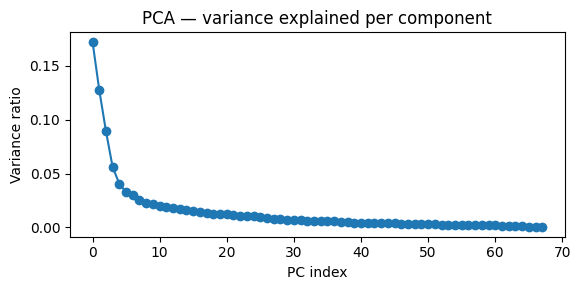

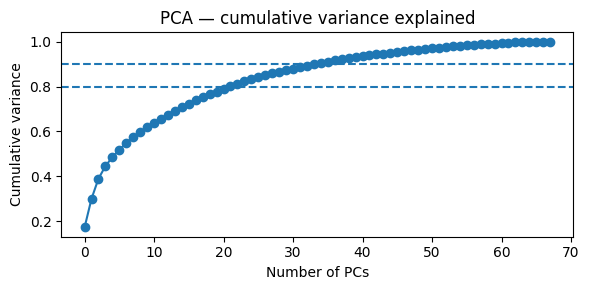

In [42]:
# Investigate the variance accounted for by each principal component.

evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)

print("First 10 PCs variance ratio:", np.round(evr[:10], 4))
print("Cumulative @ 10 PCs:", np.round(cum[9], 4))
print("Cumulative @ 20 PCs:", np.round(cum[19], 4))
print("Cumulative @ 30 PCs:", np.round(cum[29], 4))

plt.figure(figsize=(6,3))
plt.plot(evr, marker='o')
plt.title("PCA — variance explained per component")
plt.xlabel("PC index"); plt.ylabel("Variance ratio")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(cum, marker='o')
plt.axhline(0.80, ls='--'); plt.axhline(0.90, ls='--')
plt.title("PCA — cumulative variance explained")
plt.xlabel("Number of PCs"); plt.ylabel("Cumulative variance")
plt.tight_layout(); plt.show()

In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(features_scaled)

print("X_pca shape:", X_pca.shape)
print("Explained variance (cum):", pca.explained_variance_ratio_.sum().round(4))

X_pca shape: (797384, 30)
Explained variance (cum): 0.873


### Discussion 2.2: Perform Dimensionality Reduction

After scaling, I applied PCA to reduce dimensionality. Looking at the cumulative explained variance curve, I saw that around 25–35 components already capture most of the variance, with ~87% explained at 30 components. To keep the analysis simple and reproducible, I decided to fix the number of components at 30. This choice keeps enough information for clustering while avoiding unnecessary complexity from including too many dimensions. I also tested nearby values (25 and 35 components) and saw very similar variance levels, which gave me confidence that 30 is a reasonable stopping point. The transformed dataset has shape (797,384 × 30) and is now ready for clustering.

### Step 2.3: Interpret Principal Components

After transforming the data with PCA, the feature weights (loadings) of the leading components are inspected to support interpretation.

Each principal component represents a direction of high variance in the scaled feature space. Features with larger absolute weights contribute more strongly to that component. Features with weights of the same sign are expected to vary in the same direction, while opposite signs suggest an inverse relationship along that component.

To analyze each component, PCA weights are mapped back to their corresponding feature names and sorted by value. The most informative variables are taken from both ends of the sorted list (largest positive and largest negative weights). The `Data_Dictionary.md` file is used to interpret what these prominent features represent and what high or low scores on the component may imply.

Interpretations are produced for the first three principal components. For repeatability, a small helper function is implemented to display the sorted feature weights for an arbitrary component index, which can also be reused later when analyzing cluster characteristics.

In [44]:
def print_pc_weights(pca, comp_idx, feature_names, top_n=10):

    
    weights = pca.components_[comp_idx]
    loadings = pd.Series(weights, index=feature_names)
    
    sorted_loads = loadings.abs().sort_values(ascending=False)
    
    print(f"\nPrincipal Component {comp_idx+1} — Top {top_n} Features (by |weight|):")
    for feat in sorted_loads.head(top_n).index:
        sign = " +" if loadings[feat] > 0 else " -"
        print(f"{feat:25s} {sign}{abs(loadings[feat]):.4f}")
    
    return loadings

In [45]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

feature_names = azdias_clean.columns.tolist()

# First PC loadings
pc1_loadings = pd.Series(pca.components_[0], index=feature_names)

# Sort and print
pc1_sorted = pc1_loadings.sort_values()
print("Principal Component 1 — sorted weights:")
print(pc1_sorted)

Principal Component 1 — sorted weights:
MOBI_REGIO              -0.236964
PLZ8_ANTG1              -0.224062
KBA05_ANTG1             -0.216845
KBA05_GBZ               -0.211409
FINANZ_MINIMALIST       -0.200265
KONSUMNAEHE             -0.167255
PLZ8_GBZ                -0.166609
INNENSTADT              -0.163840
LP_LEBENSPHASE_FEIN     -0.146004
LP_LEBENSPHASE_GROB     -0.131984
BALLRAUM                -0.126527
CAMEO_INTL_LIFESTAGE    -0.118124
GEBAEUDETYP_RASTER      -0.117246
GREEN_AVANTGARDE        -0.102997
PJ_MOVEMENT             -0.102997
ANZ_PERSONEN            -0.095031
ALTERSKATEGORIE_GROB    -0.087030
FINANZ_VORSORGER        -0.085303
WOHNLAGE                -0.085291
KBA13_ANZAHL_PKW        -0.078179
ONLINE_AFFINITAET       -0.064211
OST_WEST_KZ             -0.053818
WOHNDAUER_2008          -0.053519
SEMIO_ERL               -0.052378
MIN_GEBAEUDEJAHR        -0.051015
SEMIO_LUST              -0.050027
SEMIO_VERT              -0.040863
ANZ_TITEL               -0.003346
SOHO_KZ 

In [46]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2_loadings = pd.Series(pca.components_[1], index=feature_names)

# Sort and print
pc2_sorted = pc2_loadings.sort_values()
print("Principal Component 2 — sorted weights:")
print(pc2_sorted)


Principal Component 2 — sorted weights:
SEMIO_REL               -0.264500
PJ_DECADE               -0.262092
FINANZ_SPARER           -0.251687
SEMIO_TRADV             -0.239938
SEMIO_PFLICHT           -0.239596
FINANZ_UNAUFFAELLIGER   -0.233743
SEMIO_KULT              -0.224175
FINANZ_ANLEGER          -0.212689
SEMIO_FAM               -0.189494
SEMIO_RAT               -0.181600
SEMIO_MAT               -0.170308
ONLINE_AFFINITAET       -0.159120
SEMIO_SOZ               -0.104986
SEMIO_VERT              -0.061651
HEALTH_TYP              -0.060476
PLZ8_ANTG1              -0.059568
KBA05_GBZ               -0.056565
MOBI_REGIO              -0.055132
ANZ_PERSONEN            -0.054314
INNENSTADT              -0.052912
PLZ8_GBZ                -0.048234
KONSUMNAEHE             -0.048092
KBA05_ANTG1             -0.044470
BALLRAUM                -0.043963
WOHNLAGE                -0.043628
MIN_GEBAEUDEJAHR        -0.042305
LP_LEBENSPHASE_GROB     -0.032010
GEBAEUDETYP_RASTER      -0.028793
KBA13_AN

In [47]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc3_loadings = pd.Series(pca.components_[2], index=feature_names)

# Sort and print
pc3_sorted = pc3_loadings.sort_values()
print("Principal Component 3 — sorted weights:")
print(pc3_sorted)

Principal Component 3 — sorted weights:
ANREDE_KZ               -0.368788
SEMIO_KAEM              -0.337722
SEMIO_DOM               -0.313515
SEMIO_KRIT              -0.277105
SEMIO_RAT               -0.216544
FINANZ_ANLEGER          -0.189044
SEMIO_ERL               -0.177318
FINANZ_SPARER           -0.106521
PJ_DECADE               -0.105069
FINANZ_UNAUFFAELLIGER   -0.097634
SEMIO_PFLICHT           -0.078226
SEMIO_TRADV             -0.077585
ONLINE_AFFINITAET       -0.049408
FINANZ_HAUSBAUER        -0.048649
PLZ8_ANTG1              -0.040999
INNENSTADT              -0.040251
PLZ8_GBZ                -0.034989
KONSUMNAEHE             -0.034493
BALLRAUM                -0.033064
GEBAEUDETYP_RASTER      -0.028294
HH_EINKOMMEN_SCORE      -0.027194
KBA13_ANZAHL_PKW        -0.021908
MOBI_REGIO              -0.021722
WOHNLAGE                -0.021546
HEALTH_TYP              -0.021327
KBA05_GBZ               -0.019154
KKK                     -0.018767
MIN_GEBAEUDEJAHR        -0.015568
KBA05_AN

### Discussion 2.3: Interpret Principal Components

To better understand what the first few principal components represent, I inspected the feature loadings.

PC1 showed strong negative weights for variables related to urbanization and minimalistic financial profiles (e.g., MOBI_REGIO, PLZ8_ANTG1, KBA05_GBZ) and strong positive weights for wealth and household indicators (e.g., CAMEO_INTL_WEALTH, HH_EINKOMMEN_SCORE, EWDICHTE). This suggests PC1 contrasts lower-income, rural/minimalist households with higher-income, urban/wealthy ones.

PC2 had large negative weights for traditional, religious, and saver profiles (e.g., SEMIO_REL, SEMIO_TRADV, FINANZ_SPARER) and positive weights for modern/expressive tendencies (e.g., SEMIO_ERL, SEMIO_LUST, FINANZ_VORSORGER). This indicates PC2 separates conservative, saving-oriented households from more progressive, expressive ones.

PC3 highlighted a contrast between rational/critical orientations (e.g., SEMIO_KRIT, SEMIO_RAT, FINANZ_ANLEGER, all negative) and emotional/social orientations (e.g., SEMIO_SOZ, SEMIO_VERT, SEMIO_FAM, positive). So PC3 can be seen as a spectrum from analytic/critical lifestyles to socially expressive and family-oriented lifestyles.

Overall, these first three components seem to capture meaningful demographic and lifestyle contrasts economic status, traditional vs. progressive attitudes, and rational vs. social orientations.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

After preprocessing, scaling, and PCA transformation, clustering is performed in the reduced feature space to identify population segments.

K-means clustering (`sklearn.cluster.KMeans`) is applied to the PCA-transformed dataset. For each candidate number of clusters, the average within-cluster distance to centroids is computed (e.g., derived from the model score/inertia), and the trend is evaluated across multiple values of k. Using the elbow-style trade-off between model complexity and marginal improvement, an appropriate final cluster count is selected.

Finally, K-means is re-fitted using the chosen number of clusters, and the resulting cluster assignments for the general population dataset are stored for later comparison with the customer dataset in Step 3.3.

In [48]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.

Ks = range(2, 16) 
results = []

for k in Ks:
    t0 = time.time()
    mbk = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=8192,
        n_init="auto"
    )
    mbk.fit(X_pca) 

    inertia = mbk.inertia_
    n = X_pca.shape[0]
    avg_sse = inertia / n                  
    avg_rmsd = np.sqrt(avg_sse)            

    elapsed = time.time() - t0
    results.append((k, inertia, avg_sse, avg_rmsd, elapsed))
    print(f"k={k:2d} | inertia={inertia:,.0f} | avg_sse={avg_sse:.4f} | rmsd={avg_rmsd:.4f} | {elapsed:.1f}s")

results_arr = np.array(results, dtype=object)

k= 2 | inertia=40,335,304 | avg_sse=50.5845 | rmsd=7.1123 | 0.5s
k= 3 | inertia=37,223,352 | avg_sse=46.6818 | rmsd=6.8324 | 0.4s
k= 4 | inertia=35,352,144 | avg_sse=44.3352 | rmsd=6.6585 | 0.4s
k= 5 | inertia=33,968,344 | avg_sse=42.5997 | rmsd=6.5268 | 0.4s
k= 6 | inertia=32,820,000 | avg_sse=41.1596 | rmsd=6.4156 | 0.5s
k= 7 | inertia=31,639,440 | avg_sse=39.6791 | rmsd=6.2991 | 0.6s
k= 8 | inertia=30,769,848 | avg_sse=38.5885 | rmsd=6.2120 | 0.5s
k= 9 | inertia=30,062,034 | avg_sse=37.7008 | rmsd=6.1401 | 0.5s
k=10 | inertia=29,429,332 | avg_sse=36.9074 | rmsd=6.0751 | 0.5s
k=11 | inertia=28,914,680 | avg_sse=36.2619 | rmsd=6.0218 | 0.5s
k=12 | inertia=28,449,882 | avg_sse=35.6790 | rmsd=5.9732 | 0.5s
k=13 | inertia=28,103,736 | avg_sse=35.2449 | rmsd=5.9367 | 0.5s
k=14 | inertia=27,763,622 | avg_sse=34.8184 | rmsd=5.9007 | 0.5s
k=15 | inertia=27,485,910 | avg_sse=34.4701 | rmsd=5.8711 | 0.6s


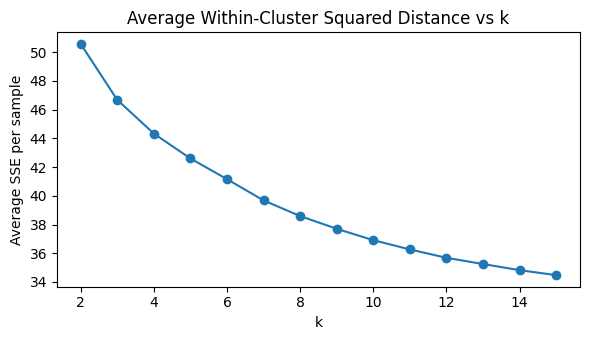

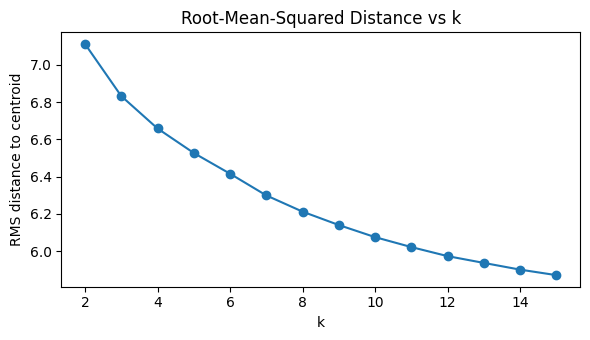

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
ks = results_arr[:,0].astype(int)
avg_sse = results_arr[:,2].astype(float)
avg_rmsd = results_arr[:,3].astype(float)

plt.figure(figsize=(6,3.5))
plt.plot(ks, avg_sse, marker="o")
plt.title("Average Within-Cluster Squared Distance vs k")
plt.xlabel("k")
plt.ylabel("Average SSE per sample")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3.5))
plt.plot(ks, avg_rmsd, marker="o")
plt.title("Root-Mean-Squared Distance vs k")
plt.xlabel("k")
plt.ylabel("RMS distance to centroid")
plt.tight_layout()
plt.show()

In [50]:
cand_ks = [6,7,8]
sil_scores = {}

for k in cand_ks:
    km = MiniBatchKMeans(n_clusters=k, batch_size=8192, n_init="auto", random_state=42)
    labels = km.fit_predict(X_pca) 
    sil = silhouette_score(X_pca, labels, sample_size=10_000, random_state=42)
    sil_scores[k] = sil
    print(f"k={k}  silhouette≈ {sil:.3f}")

best_k = max(sil_scores, key=sil_scores.get)
print("Best k:", best_k)

k=6  silhouette≈ 0.098
k=7  silhouette≈ 0.089
k=8  silhouette≈ 0.095
Best k: 6


In [51]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k_final =6

kmeans = MiniBatchKMeans(
    n_clusters=k_final,
    random_state=42,
    batch_size=8192,
    n_init="auto"
).fit(X_pca)

azdias_clusters = kmeans.labels_          
print("Cluster label counts:", np.bincount(azdias_clusters))

Cluster label counts: [161398 156028 108109 115823 127717 128309]


### Discussion 3.1: Apply Clustering to General Population

To segment the general population, I applied k-means clustering on the PCA-transformed data. I compared different values of k using the elbow method and silhouette scores. The elbow curve showed diminishing returns after 6–8 clusters, and the silhouette analysis confirmed that k = 6 gave the best score (≈0.098). The resulting clusters are well balanced, each representing about 13–20% of the dataset. I chose k=6 as the final model because it offers both interpretability and stability. In the next step, I will use this model (with the fitted scaler, PCA, and k-means) to assign clusters to the customers and compare distributions to identify over-represented segments.

### Step 3.2: Apply All Steps to the Customer Data

After clusters have been learned from the general population, the customer dataset is processed using the same preprocessing and modeling pipeline. The models are not re-fitted on customer data; instead, the transformations learned from the general population are reused to ensure a consistent mapping.

The customer data is loaded using the semicolon (`;`) delimiter.

The previously defined `clean_data()` function is applied to perform the same feature selection, encoding, and mixed-feature engineering steps.

The fitted sklearn objects from the general population workflow (imputer/scaler, PCA, and KMeans) are then applied sequentially using `.transform()` / `.predict()` (without calling .fit() or `.fit_transform()`), producing cluster assignments for each customer record.

In [52]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")
print(customers.shape)

(191652, 85)


In [53]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers, missing_map=missing_map, feat_info=feat_info)

missing_in_cust = set(azdias_clean.columns) - set(customers_clean.columns)
extra_in_cust   = set(customers_clean.columns) - set(azdias_clean.columns)
print("Missing in CUSTOMERS:", sorted(list(missing_in_cust))[:10])
print("Extra in CUSTOMERS  :", sorted(list(extra_in_cust))[:10])

customers_clean = customers_clean.reindex(columns=azdias_clean.columns)

C_imp  = imputer.transform(customers_clean)     
C_std  = scaler.transform(C_imp)              
C_pca  = pca.transform(C_std)                 
cust_labels = kmeans.predict(C_pca)            

print("Customer cluster counts:", np.bincount(cust_labels))

Missing in CUSTOMERS: []
Extra in CUSTOMERS  : []
Customer cluster counts: [15702 26630 67275 15565  2127 14343]


### Step 3.3: Compare Customer Data to Demographics Data

In this final step, cluster memberships from the general population are compared against the cluster assignments of the customer dataset to identify which population segments are most strongly associated with the company’s customer base.

Cluster proportions are computed separately for the general population and for customers, and the differences (or ratios) in representation are visualized (e.g., with bar charts). If a high-missingness subset was separated earlier in Step 1.1.3 and found to be qualitatively distinct, it is treated as an additional group in this comparison and its size is included when calculating proportions for both datasets.

Clusters that are overrepresented among customers (relative to the population baseline) are interpreted as likely target segments. At least one such cluster is examined in detail by relating its characteristics to the principal component loadings from Step 2.3, or by transforming cluster centroids back into the original feature space using the fitted scaler/PCA (inverse_transform) for direct interpretation.

A similar analysis is performed for underrepresented clusters, which indicate demographic segments that are less aligned with the company’s customer profile.

In [54]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

k_final = kmeans.n_clusters
pop_counts = np.bincount(azdias_clusters, minlength=k_final)
pop_share  = pop_counts / pop_counts.sum()
cust_counts = np.bincount(cust_labels, minlength=k_final)
cust_share  = cust_counts / cust_counts.sum()
lift = cust_share / pop_share

summary = (pd.DataFrame({
    "cluster": np.arange(k_final),
    "pop_count": pop_counts,
    "pop_share": pop_share,
    "cust_count": cust_counts,
    "cust_share": cust_share,
    "lift": lift
}).sort_values("lift", ascending=False))

display(summary.round(4))

over_id  = int(summary.iloc[0]["cluster"])
under_id = int(summary.iloc[-1]["cluster"])
print("Overrepresented cluster:", over_id, "| Underrepresented cluster:", under_id)

,cluster,pop_count,pop_share,cust_count,cust_share,lift
2,2,108109,0.1356,67275,0.4750,3.5032
1,1,156028,0.1957,26630,0.1880,0.9608
3,3,115823,0.1453,15565,0.1099,0.7565
5,5,128309,0.1609,14343,0.1013,0.6293
0,0,161398,0.2024,15702,0.1109,0.5477
4,4,127717,0.1602,2127,0.0150,0.0938


Overrepresented cluster: 2 | Underrepresented cluster: 4


In [55]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

feat_names = azdias_clean.columns.tolist()

def describe_cluster_z(cluster_id, kmeans, pca, feature_names, top_n=10):
    """
    Prints signed PC contributions and TOP +/- deviations (z-scores)
    for the centroid of a given cluster. Works with MANUAL scaling path.
    """
    center_pc = kmeans.cluster_centers_[cluster_id]

    pc_signed = pd.Series(center_pc, index=[f"PC{i+1}" for i in range(len(center_pc))])
    print(f"\nCluster {cluster_id} — signed PC contributions (top 5 by |value|):")
    display(pc_signed.reindex(pc_signed.abs().sort_values(ascending=False).head(5).index))

    center_z = pca.inverse_transform(center_pc) 
    z_series = pd.Series(center_z, index=feature_names)

    top_pos = z_series.sort_values(ascending=False).head(top_n)
    top_neg = z_series.sort_values(ascending=True).head(top_n)

    print(f"\nCluster {cluster_id} — top + deviations (higher than pop mean):")
    display(top_pos)
    print(f"\nCluster {cluster_id} — top - deviations (lower than pop mean):")
    display(top_neg)

In [56]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Describe the MOST overrepresented cluster
describe_cluster_z(over_id,  kmeans, pca, feat_names, top_n=10)

# Describe the MOST underrepresented cluster
describe_cluster_z(under_id, kmeans, pca, feat_names, top_n=10)


Cluster 2 — signed PC contributions (top 5 by |value|):


PC1   -3.311315
PC4    2.407993
PC2    1.480770
PC3    1.018020
PC5   -0.523161
dtype: float32


Cluster 2 — top + deviations (higher than pop mean):


PJ_MOVEMENT             1.640689
GREEN_AVANTGARDE        1.640688
FINANZ_MINIMALIST       1.100123
KBA05_ANTG1             0.911609
MOBI_REGIO              0.842891
KBA05_GBZ               0.712637
FINANZ_VORSORGER        0.699171
LP_LEBENSPHASE_FEIN     0.672442
ALTERSKATEGORIE_GROB    0.616810
LP_LEBENSPHASE_GROB     0.584190
dtype: float32


Cluster 2 — top - deviations (lower than pop mean):


HH_EINKOMMEN_SCORE   -1.219182
FINANZ_SPARER        -0.862875
FINANZ_ANLEGER       -0.856521
CAMEO_INTL_WEALTH    -0.804367
PJ_DECADE            -0.646061
SEMIO_PFLICHT        -0.614042
FINANZ_HAUSBAUER     -0.610770
KKK                  -0.569779
WOHNLAGE             -0.569600
SEMIO_RAT            -0.550509
dtype: float32


Cluster 4 — signed PC contributions (top 5 by |value|):


PC3   -2.643796
PC1    2.475964
PC2   -2.377183
PC9    0.538315
PC5   -0.325855
dtype: float32


Cluster 4 — top + deviations (higher than pop mean):


SEMIO_RAT                1.375993
SEMIO_PFLICHT            1.124881
SEMIO_TRADV              1.108800
FINANZ_SPARER            1.055091
FINANZ_ANLEGER           0.986579
PJ_DECADE                0.914613
FINANZ_UNAUFFAELLIGER    0.869612
ANREDE_KZ                0.861164
SEMIO_REL                0.804913
SEMIO_KAEM               0.776880
dtype: float32


Cluster 4 — top - deviations (lower than pop mean):


ALTERSKATEGORIE_GROB   -1.161319
FINANZ_MINIMALIST      -1.146037
SEMIO_VERT             -0.935223
FINANZ_VORSORGER       -0.905474
RETOURTYP_BK_S         -0.687140
SEMIO_LUST             -0.653271
SEMIO_SOZ              -0.506517
MOBI_REGIO             -0.360367
KBA05_ANTG1            -0.353618
WOHNDAUER_2008         -0.342434
dtype: float32

### Discussion 3.3: Compare Customer Data to Demographics Data

When comparing the general population with the customer base, the distribution across clusters shows clear differences. Cluster 2 is strongly over-represented (47.5% of customers vs. 13.6% of the population, lift ≈ 3.5), reflecting younger, mobile, avant-garde households that are trend-oriented but more price-sensitive. In contrast, Cluster 4 is heavily under-represented (1.5% vs. 16%, lift ≈ 0.09) and corresponds to more traditional, saver-oriented, rural groups with lower modern lifestyle indicators. The other clusters lie in between, but the sharp contrast between Clusters 2 and 4 highlights that the company resonates most with modern, younger consumers, while more conservative segments remain less engaged.